In [1]:
"""General methyl data import using MSM package. General dictonary data, beta value methylation array df, survival metadata df"""

import sys
sys.path.insert(0, '/Users/zacksiegfried/Documents/methylspan')
import MSM

all_files = MSM.pullMethylMetaData('pancreas')

# not gaureteed to return same number of cases, (remove file_id from sample data if missing from meta data)
# missing values dropped anyways in next steps
sample_data = MSM.methylDataFormat(all_files, 471)
meta_data = MSM.metaDataFormat(sample_data, all_files)

Number of methylation files for all cases for primary site pancreas: 471
Final number of cases in methylation dataset : 435
Final number of cases in metadata dataset : 426


In [6]:
### PCA (NEEDS REWORK FOR DEAD + ALIVE CASES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def pcaModel(sample_df, meta_df):

    ### DEALING WITH MISSING VALUES
    # drop any cpg site that has one patient missing it
    sample_df = sample_df.dropna(axis=1, how='any')

    #scale predictor variables
    pca = PCA()
    X_reduced = pca.fit_transform(scale(sample_df))

    #define cross validation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    regr = LinearRegression()
    mse = []

    # Calculate MSE with only the intercept
    score = -1 * model_selection.cross_val_score(regr, np.ones((len(X_reduced),1)), meta_df, cv=cv, scoring='neg_mean_squared_error').mean()    
    mse.append(score)

    # Calculate MSE using cross-validation, adding one component at a time 
    for i in np.arange(1, 30): # SETS PCA RANGE (ADDS TIME)
        score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], meta_df, cv=cv, scoring='neg_mean_squared_error').mean()
        mse.append(score)

    plt.plot(mse)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('value')


pcaModel(sample_data, meta_data)

ValueError: Found input variables with inconsistent numbers of samples: [435, 426]

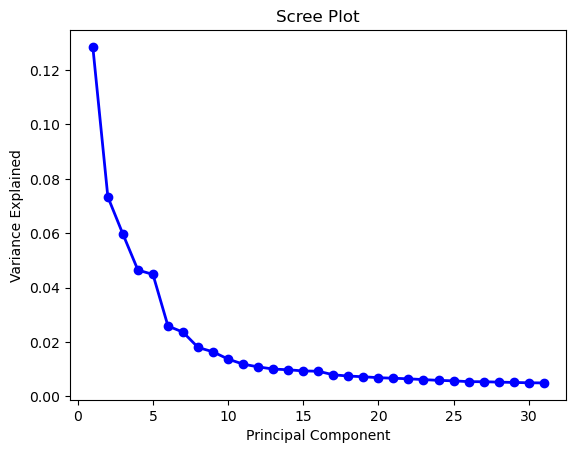

Number of PCs to achieve 0.5 explained variance: 15
Number of PCs to achieve 0.8 explained variance: 31


In [12]:
### PCA scree plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import SparsePCA

def pcaTest(sample_df, components=25):

    ### DEALING WITH MISSING VALUES
    # drop any cpg site that has one patient missing it
    sample_df = sample_df.dropna(axis=1, how='any')

    #creates scaled version of DataFrame
    scaled_df = sample_df.copy()
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(scaled_df), index=scaled_df.index, columns=scaled_df.columns)

    #scale predictor variables
    pca = PCA(n_components=components)
    pca.fit(scaled_df)

    output = pca.transform(scaled_df)

    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()

    var = 0
    count = 0
    for i in pca.explained_variance_ratio_:
        var += i 
        count += 1
        if var > 0.5:
            break
    print("Number of PCs to achieve 0.5 explained variance: " + str(count))

    var = 0
    count = 0
    for i in pca.explained_variance_ratio_:
        var += i 
        count += 1
        if var > 0.8:
            break
    print("Number of PCs to achieve 0.8 explained variance: " + str(count))

pcaTest(sample_data, 0.6)

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import MiniBatchSparsePCA

def applySPCA(sample_df, meta_data, components=25):

    meta_data = meta_data

    sample_df = sample_df.dropna(axis=1, how='any')
    scaled_df = sample_df.copy()
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(scaled_df), index=scaled_df.index, columns=scaled_df.columns)

    pca = MiniBatchSparsePCA(n_components=components)
    pca.fit(scaled_df)

    output = pca.transform(scaled_df)
    x = pd.DataFrame(output, index=scaled_df.index)

    x.index.name = 'id'
    meta_data.index.name = 'id'

    # merges dfs and formats 
    full_data = pd.merge(meta_data, x, on = 'id')
    full_data.replace(['Dead', 'Alive'],[0, 1], inplace=True)
    full_data = full_data[full_data['days_to_death'].notna()]

    print(full_data.shape)
    print(pca.components_)
    return(full_data)

spca = applySPCA(sample_data, meta_data, 15)


(400, 17)
[[ 0.00000000e+00 -1.84740838e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.10265224e-04  0.00000000e+00 -7.42056758e-04 ...  1.79403360e-03
   2.07741311e-03  1.66108700e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.42812490e-05
   0.00000000e+00  0.00000000e+00]
 ...
 [-2.91751657e-04 -3.21199570e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.63998836e-03]
 [-1.87199817e-04  3.56266925e-03  0.00000000e+00 ...  0.00000000e+00
   5.19127265e-04  0.00000000e+00]
 [ 0.00000000e+00  1.63036267e-03  6.96481885e-04 ...  0.00000000e+00
   0.00000000e+00  1.02204382e-03]]


In [25]:
### SURVIVAL ANALYSIS EXECUTION & TESTING

from lifelines import CoxPHFitter
from lifelines.calibration import survival_probability_calibration
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
cph.fit(spca, duration_col='days_to_death', event_col='vital_status')

print(cph.confidence_intervals_)
print(cph.concordance_index_)
print(cph.check_assumptions(spca))

# Predictions
scores = k_fold_cross_validation(cph, spca, 'days_to_death', event_col='vital_status', k=5, scoring_method="concordance_index")
print(scores)

/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")
/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")
/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.

           95% lower-bound  95% upper-bound
covariate                                  
0                -0.002308         0.003709
1                -0.005198        -0.001073
2                -0.000886         0.007838
3                -0.001495         0.006096
4                -0.008174         0.000372
5                -0.008411         0.004098
6                -0.003342         0.001853
7                -0.010013         0.000204
8                -0.006650        -0.001093
9                -0.007613        -0.000035
10               -0.005417        -0.001964
11               -0.002625         0.002173
12               -0.005722         0.006168
13               -0.004739         0.000667
14               -0.000004         0.003170
0.6886381123364965
Proportional hazard assumption looks okay.
[]
[0.6710963455149501, 0.6905754795663053, 0.672627235213205, 0.6197916666666666, 0.6247086247086248]


/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")
